## Considering a fundamental factor model for player pricing on Football Index

We wish to consider what factors primarily drive individual player prices on football index using an OLS regression analysis of a few fundamental factors. Further, we identify which players may be outlying in terms of price, and are points of interest when looking to trade for value on the index.

In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

First, we import our pre-cleaned model data, and generate indicator variables denoting the position that a given footballer plays in.

In [5]:
# Import and wrangle model data
path = 'file:///C:/Users/micha/Documents/Quant/football_index/model_data.csv'
df = pd.read_csv(path)
df.set_index('PlayerName', inplace=True)

# Generate positional dummies
df = pd.get_dummies(df, prefix='', prefix_sep='')

# Regress
y = df['CurrentPrice']
X = df[['Age', 'ave_matchday_score', 'Forward',
        'Midfielder', 'Defender', 'Goalkeeper']]

Since we are using OLS modelling we first check we do not have a multicollinearity problem within the explanatory variable matrix, as this can either break the OLS regression entirely or at least make coefficient estimates associated with the regressors affected unstable. 

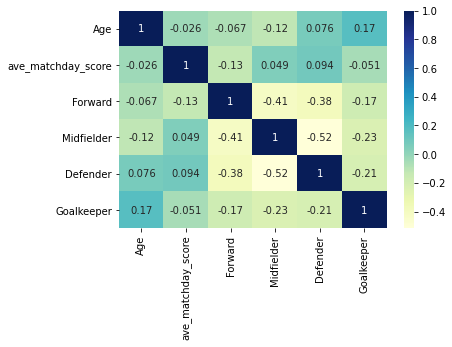

In [22]:
# Check for multicollinearity among explanatory vars
corr_table = X.corr()
sns.heatmap(corr_table, annot=True, cmap="YlGnBu");

Plotting a correlation matrix, we see that our regressors are mostly independent of eachother, so continue with our first regression. 

Note that we specify the use of White-Huber heteroskedasticity robust standard errors for our coefficient estimates. These are good practice to use blindly as a rule of thumb with most regression specifications, but especially in our following regressions since we use indicator variables to denote player position. We expect that the variance of errors in our model, (homogenous across player position types), will be different for players across these positions.

In [25]:
# Proceed w/ basic OLS model
model = sm.OLS(y, X).fit(cov_type='HC0')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CurrentPrice   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 03 Dec 2020   Prob (F-statistic):                nan
Time:                        10:16:33   Log-Likelihood:                -1380.4
No. Observations:                1358   AIC:                             2773.
Df Residuals:                    1352   BIC:                             2804.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.0641      0.006    -11.439      0.000      -0.075      -0.053
ave_matchday_score     0.0093      0.001      9.977      0.000       0.007       0.011
Forward                2.2519      0.156     14.424      0.000       1.946       2.558
Midfielder             1.8854      0.154     12.239      0.000       1.584       2.187
Defender               1.6859      0.155     10.855      0.000       1.381       1.990
Goalkeeper             1.7877      0.162     11.060      0.000       1.471       2.105
==============================================================================
Omnibus:                     1252.217   Durbin-Watson:                   1.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51950.702
Skew:                           4.248   Prob(JB):                         0.00
Kurtosis:                      32.085   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The results from our first (basic) model displays that all our features are strongly statistically significant. 

However, we are very likely over-simplifying the true underlying price generating process with such a basic model, so we elect to consider if age and average matchday scores may have more complex non-linear relationships with player prices. To do this, we examine conditional residual plots, controlling for the rest of the variables included in the above regression model.

Considering first the relationship between the shape of residuals and player age, conditonal on our other variables. We see that the residuals are definitely not evenly distributed above and below the regression line. There seem to be more large positive residuals located near lower age groups.

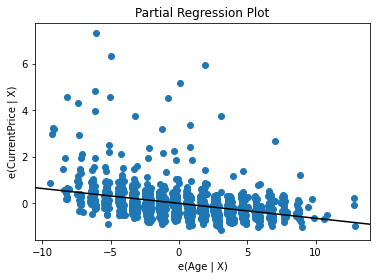

In [15]:
# Consider partial regression plots
sm.graphics.plot_partregress('CurrentPrice', 'Age', 
                             ['ave_matchday_score', 'Forward', 'Midfielder', 
                              'Defender', 'Goalkeeper'], 
                             data=df, obs_labels=False);

A similar effect seems to be in action with those players with very high average matchday scores, again indicating we have not fully captured the true relationship between matchday scores and player pricing.

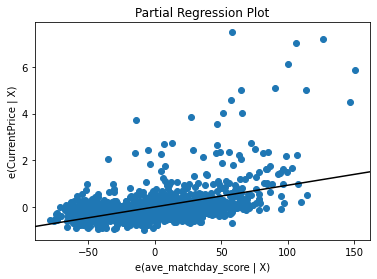

In [16]:
sm.graphics.plot_partregress('CurrentPrice', 'ave_matchday_score', 
                             ['Age', 'Forward', 'Midfielder', 
                              'Defender', 'Goalkeeper'],
                              data=df, obs_labels=False);

In light of the above plots we re-specify a regression model to include two quadratic transformations of age and average matchday score. 

Note that we center these variables before transforming them. This relieves some of the linear correlation between the age and matchday score variables and their squares. Centering does not add any predictive power or overall fit to the model, (will not effect r^2 values), however it is important if you are considering the statistical significance of individual variables in the regression. (See Iacobucci et. al. (2015) for further discussion on this https://doi.org/10.3758/s13428-015-0624-x)

In [26]:
# Since squares are going to be highly correlated w/ their lower order counterparts we center them first
to_center = df[['Age', 'ave_matchday_score']]
df_centered = to_center.subtract(to_center.mean())
positional_indicators = ['Forward', 'Midfielder', 'Defender', 'Goalkeeper']
df_centered[positional_indicators] = df[positional_indicators]


df_centered['Age2'] = df_centered['Age']**2
df_centered['ave_matchday_score2'] = df_centered['ave_matchday_score']**2

In [21]:
# Then we create a new feature matrix with these transformations and run our final model
X_adjusted = df_centered[['Age', 'Age2', 'ave_matchday_score', 'ave_matchday_score2',
        'Forward', 'Midfielder', 'Defender', 'Goalkeeper']]

model = sm.OLS(y, X_adjusted).fit(cov_type='HC0')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CurrentPrice   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 03 Dec 2020   Prob (F-statistic):                nan
Time:                        08:40:06   Log-Likelihood:                -1248.4
No. Observations:                1358   AIC:                             2513.
Df Residuals:                    1350   BIC:                             2554.
Df Model:                           7                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age                    -0.0731      0.006    -12.906      0.000      -0.084      -0.062
Age2                    0.0077      0.001      6.409      0.000       0.005       0.010
ave_matchday_score      0.0078      0.001     13.734      0.000       0.007       0.009
ave_matchday_score2     0.0001    2.1e-05      5.718      0.000     7.9e-05       0.000
Forward                 0.7741      0.049     15.885      0.000       0.679       0.870
Midfielder              0.4763      0.034     13.822      0.000       0.409       0.544
Defender                0.2499      0.039      6.429      0.000       0.174       0.326
Goalkeeper              0.3257      0.037      8.892      0.000       0.254       0.398
==============================================================================
Omnibus:                     1109.675   Durbin-Watson:                   1.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38245.562
Skew:                           3.558   Prob(JB):                         0.00
Kurtosis:                      28.006   Cond. No.                     9.28e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 9.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With our added regressors, we find a good improvement in model fit (R^2 value=0.460) despite adding little complexity and keeping the model sensical. 

### Conclusion
Nearly half (46%) of all variation in player prices can be explained by essentially 3 basic factors... 

- Player age
- Average matchday score
- Position played

Age and average matchday score appear to have a non-linear relationship with price. If age is very low, say late teens, early 20's, then these players are valued considerably higher than their slightly older counterparts. Equally, if average matchday score is superlative among peers, these players demand a premium on the index as well. 

Forwards are the highest valued players on the index, followed by midfielders, then goalkeepers and defenders. 

In [24]:
# Grab players with lowest residual values
residuals = model.resid.sort_values()
residuals.head(10)

PlayerName
Manuel Akanji      -1.966234
Mats Hummels       -1.839296
Manuel Locatelli   -1.750524
Thiago Silva       -1.686121
Gael Kakuta        -1.686041
dtype: float64

In the context of our basic model, the above 5 players seem relatively undervalued when compared to similar quality counterparts on the football index. 

Of course the above results are not solely a good reason to buy these players. First, the pricing model works on very few features and is clearly an over-simplification of the true state of the world. Second, you would be extremely liable to fundamental risk when entering into a trade, i.e. you must have reason to believe that the market will begin to value them correctly in the near future, and they will rise in price. If they are not valued accurately at present, why should they be in a month's time?

However, the model does potentially produce useful results as a basis for filtering players on the index to a shortlist, to find some that warrant further investigation.